In [7]:
import os
import torch
from torch.ao.nn.quantized import BatchNorm3d
from torch.nn import Sequential
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
import copy
import Augmentor
import shutil

In [8]:
"""
goes through data directory and check if the output directory exists
"""

root_dir = "./Data/Train"
for dirpath, dirnames, filenames in os.walk(root_dir):
        if 'output' in dirnames:
            output_path = os.path.join(dirpath, 'output')
            print(f"Deleting: {output_path}")
            shutil.rmtree(output_path)
            # Remove 'output' from dirnames to avoid walking into deleted directory
            dirnames.remove('output')

Deleting: ./Data/Train/melanoma/output
Deleting: ./Data/Train/pigmented benign keratosis/output
Deleting: ./Data/Train/nevus/output
Deleting: ./Data/Train/basal cell carcinoma/output
Deleting: ./Data/Train/actinic keratosis/output
Deleting: ./Data/Train/squamous cell carcinoma/output
Deleting: ./Data/Train/vascular lesion/output
Deleting: ./Data/Train/seborrheic keratosis/output
Deleting: ./Data/Train/dermatofibroma/output


In [9]:
# ========== CONFIG ==========
data_dir = "./Data"  # Ordner mit Unterordnern: Train/, Test/
train_dir = os.path.join(data_dir, "Train")
test_dir = os.path.join(data_dir, "Test")
batch_size = 32
num_epochs = 2
num_classes = 9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== AUGMENTOR PIPELINE ==========

class_names = [d for d in os.listdir(train_dir) if not d.startswith('.')]
path_to_training_dataset = "Data/Train"

for i in class_names:
    source_dir = os.path.join(path_to_training_dataset, i)
    p = Augmentor.Pipeline(source_dir, output_directory="output")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.sample(500)


Initialised with 438 image(s) found.
Output directory set to Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16855BBD0>: 100%|██████████| 500/500 [00:06<00:00, 71.71 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1692A1A10>: 100%|██████████| 500/500 [00:01<00:00, 268.62 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16927B010>: 100%|██████████| 500/500 [00:06<00:00, 79.69 Samples/s]                    


Initialised with 376 image(s) found.
Output directory set to Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1692EB150>: 100%|██████████| 500/500 [00:01<00:00, 309.95 Samples/s]                  


Initialised with 114 image(s) found.
Output directory set to Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1685EC310>: 100%|██████████| 500/500 [00:01<00:00, 311.74 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A51C990>: 100%|██████████| 500/500 [00:01<00:00, 325.24 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1692D0450>: 100%|██████████| 500/500 [00:01<00:00, 289.17 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1687DE0D0>: 100%|██████████| 500/500 [00:03<00:00, 145.32 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x169354E90>: 100%|██████████| 500/500 [00:01<00:00, 330.55 Samples/s]                  



Epoch 1/2
--------------------
Train Loss: 1.1747 Acc: 0.5851
Val Loss: 1.5611 Acc: 0.4746

Epoch 2/2
--------------------
Train Loss: 0.7202 Acc: 0.7642
Val Loss: 1.6453 Acc: 0.4407

Training complete in 7m 37s
Best val Acc: 0.4746


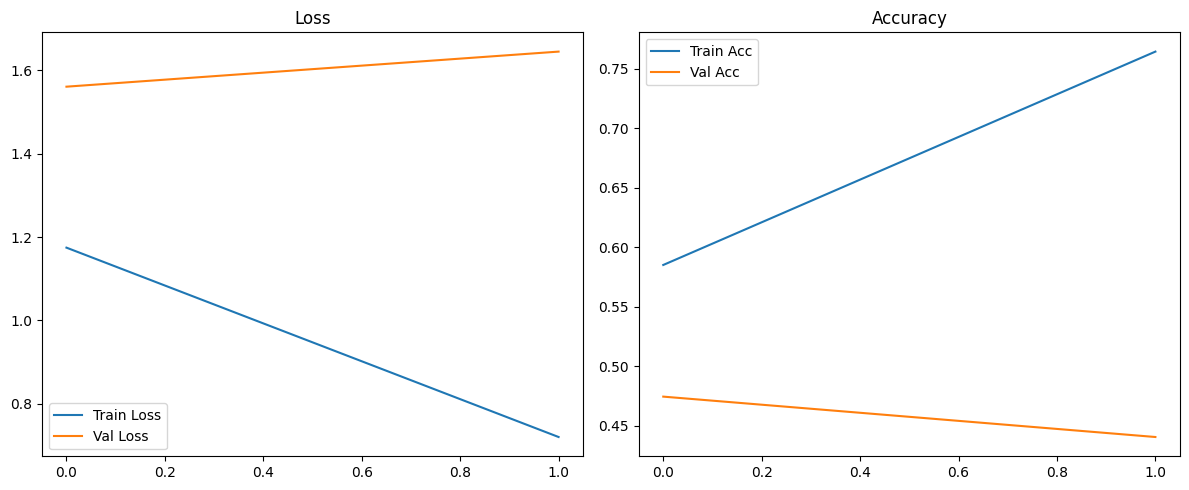

In [14]:
# ========== TRANSFORMS ==========
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# ========== DATASETS & LOADERS ==========
image_datasets = {
    "train": ImageFolder(train_dir, transform=data_transforms["train"]),
    "val": ImageFolder(test_dir, transform=data_transforms["val"])
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

# ========== MODEL SETUP ==========
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Freeze the base model parameters
#for param in list(base_model.parameters()):
#    param.requires_grad = True

# Create new classifier
model = nn.Sequential(
    base_model.features,  # Feature-Extraktion Teil von MobileNetV2
    nn.Conv2d(1280, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=0.1),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(256),
    #nn.Dropout(p=0.25),
    nn.Linear(256, num_classes)
)

#model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ========== TRAINING LOOP ==========
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# ========== START TRAINING ==========
model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, num_epochs=num_epochs)

# ========== PLOTTING ==========
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()

In [6]:
# ========== TEST-SET AUSWERTUNG ==========
def evaluate_on_test(model, test_dir, transform, batch_size=32):
    model.eval()  # Evaluation Mode

    test_dataset = ImageFolder(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    total = 0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = correct / total
    print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# ========== TESTEN ==========
evaluate_on_test(model, test_dir=test_dir, transform=data_transforms["val"])


✅ Test Accuracy: 55.08%
